**Heart Disease Classification**

In [1]:
#install tensorflow 
! pip install tensorflow
! pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 127.6 kB/s eta 0:00:00a 0:00:01


In [12]:
#import all necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import keras_tuner


**Data Visualization**
* The data has 21 feature and 2 classes
* The data is imbalanced: 23888 samples has heart disease and 229773 don't.
* The correlation heatmap indicates the correlation between every two features (bivariate) the higher the value the higher the correlation so it gives insights about the data.


In [3]:
data = pd.read_csv('heart_disease_health_indicators.csv')
print(data.head())

   HeartDiseaseorAttack  HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  \
0                     0       1         1          1   40       1       0   
1                     0       0         0          0   25       1       0   
2                     0       1         1          1   28       0       0   
3                     0       1         0          1   27       0       0   
4                     0       1         1          1   24       0       0   

   Diabetes  PhysActivity  Fruits  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
0         0             0       0  ...              1            0        5   
1         0             1       0  ...              0            1        3   
2         0             0       1  ...              1            1        5   
3         0             1       1  ...              1            0        2   
4         0             1       1  ...              1            0        2   

   MentHlth  PhysHlth  DiffWalk  Sex  Age  Education  Income  

In [4]:
#Data information
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253661 entries, 0 to 253660
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HeartDiseaseorAttack  253661 non-null  int64
 1   HighBP                253661 non-null  int64
 2   HighChol              253661 non-null  int64
 3   CholCheck             253661 non-null  int64
 4   BMI                   253661 non-null  int64
 5   Smoker                253661 non-null  int64
 6   Stroke                253661 non-null  int64
 7   Diabetes              253661 non-null  int64
 8   PhysActivity          253661 non-null  int64
 9   Fruits                253661 non-null  int64
 10  Veggies               253661 non-null  int64
 11  HvyAlcoholConsump     253661 non-null  int64
 12  AnyHealthcare         253661 non-null  int64
 13  NoDocbcCost           253661 non-null  int64
 14  GenHlth               253661 non-null  int64
 15  MentHlth              253661 non-n

In [5]:
#Check for data balance
print(data['HeartDiseaseorAttack'].value_counts())


HeartDiseaseorAttack
0    229773
1     23888
Name: count, dtype: int64


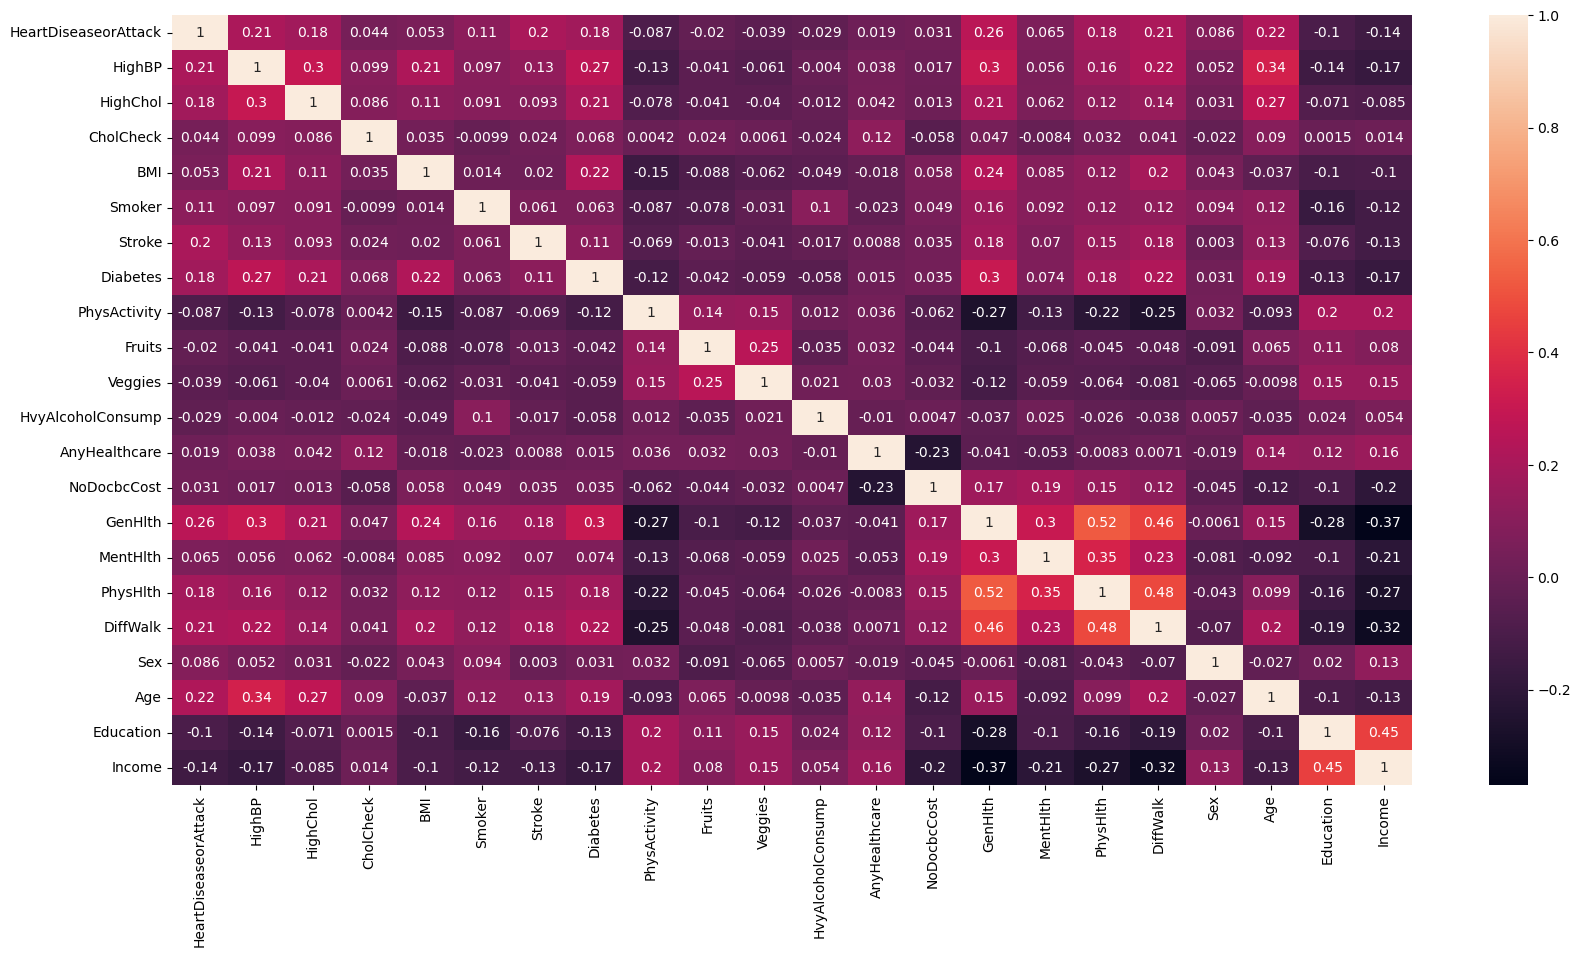

In [6]:
#Draw heatmap to check for correlation between features
plt.figure(figsize=(20,10))
sns.heatmap(data.corr(),annot=True, cbar=True)
plt.show()

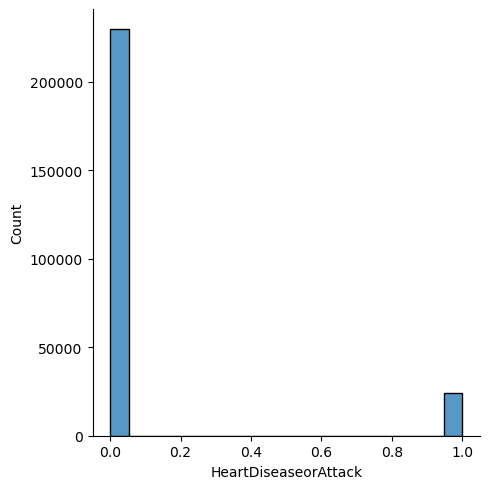

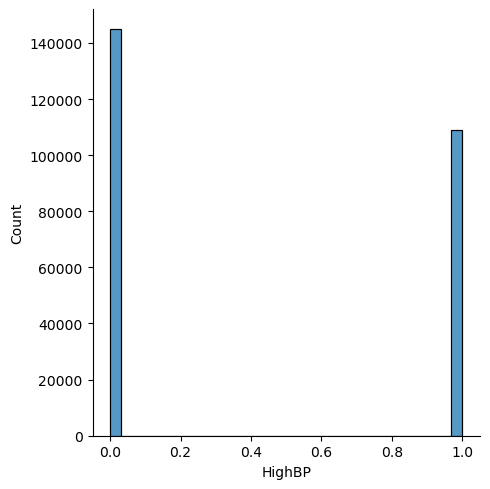

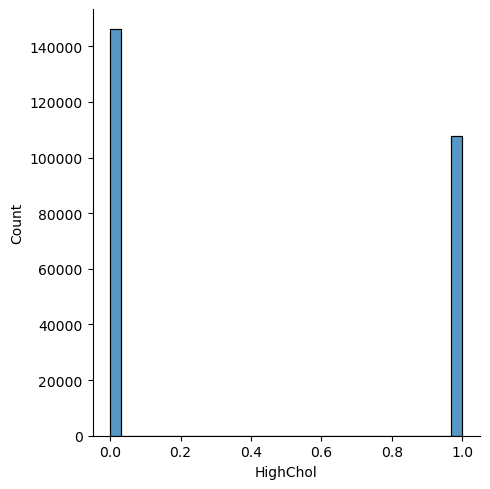

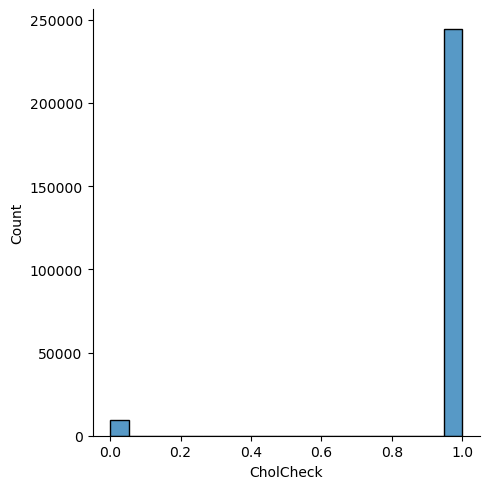

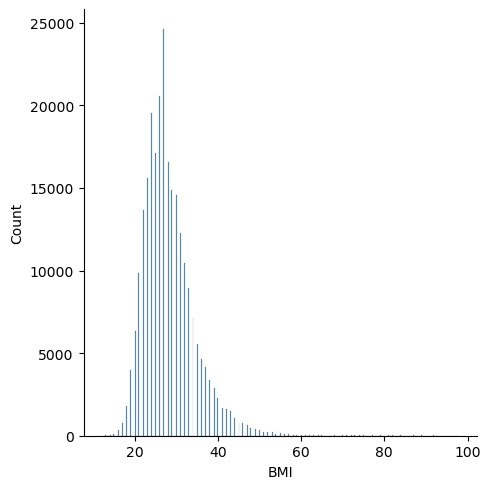

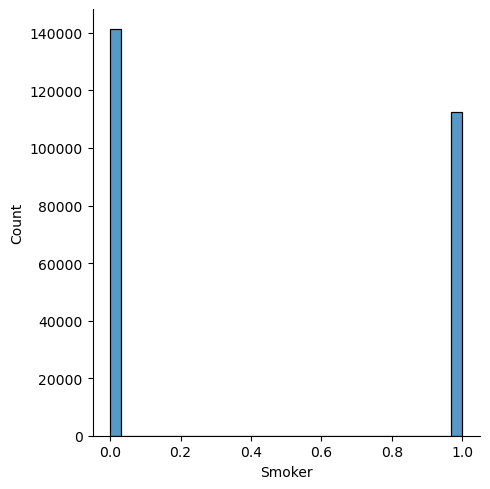

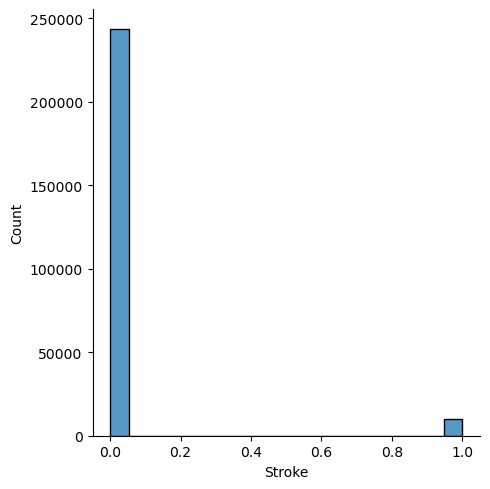

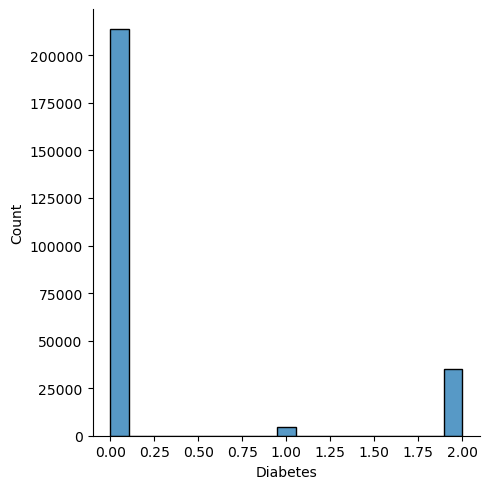

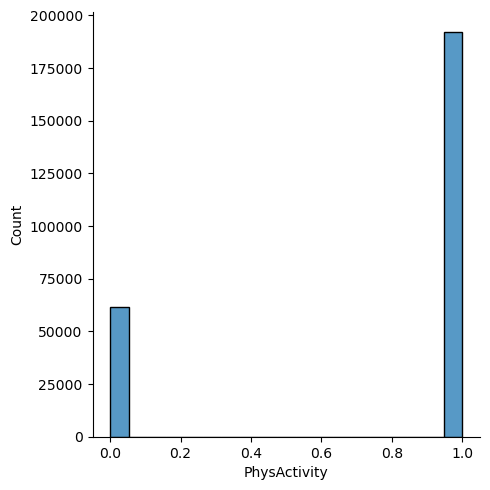

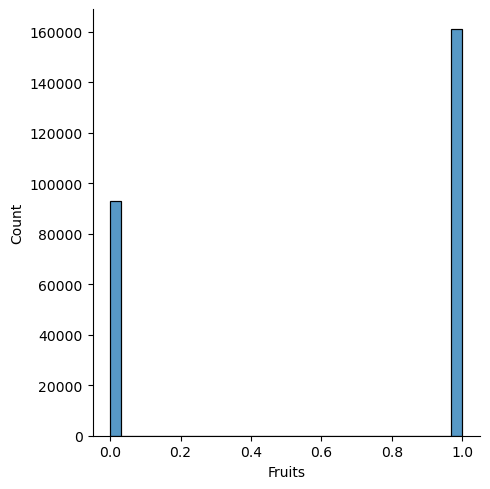

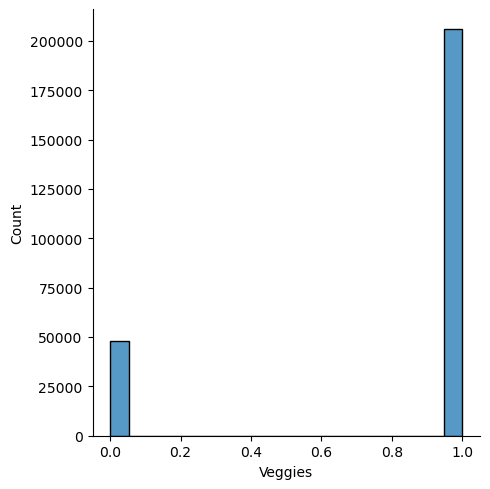

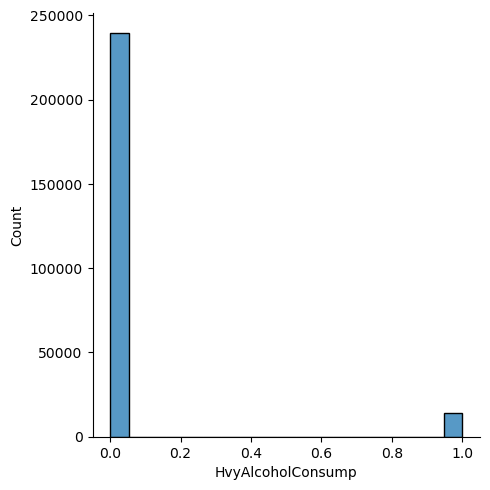

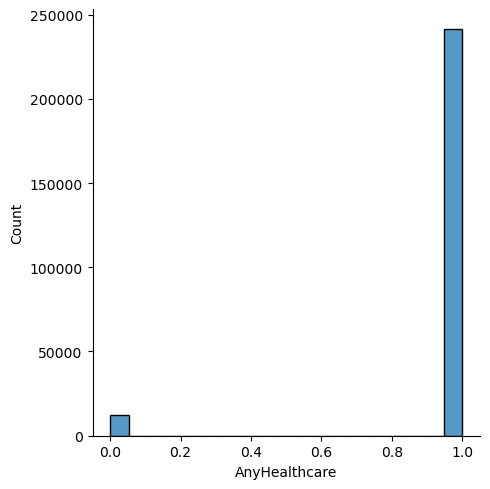

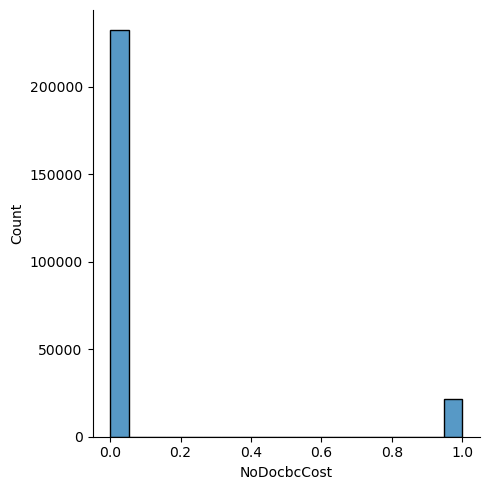

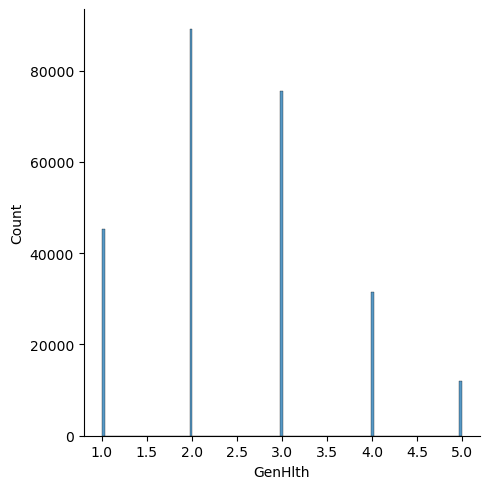

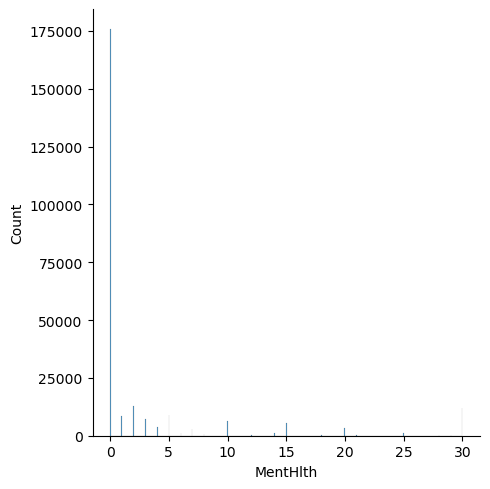

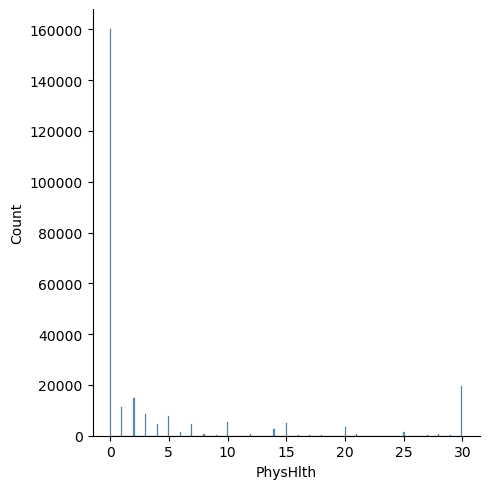

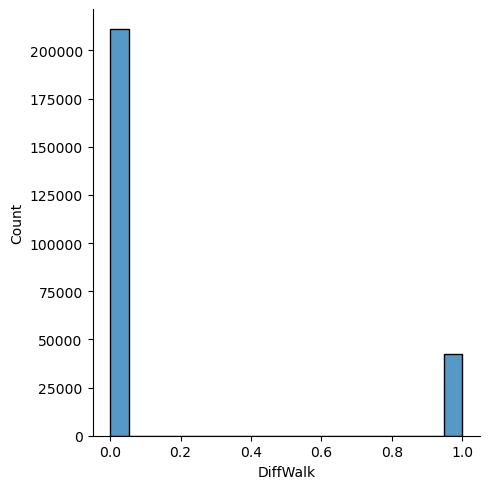

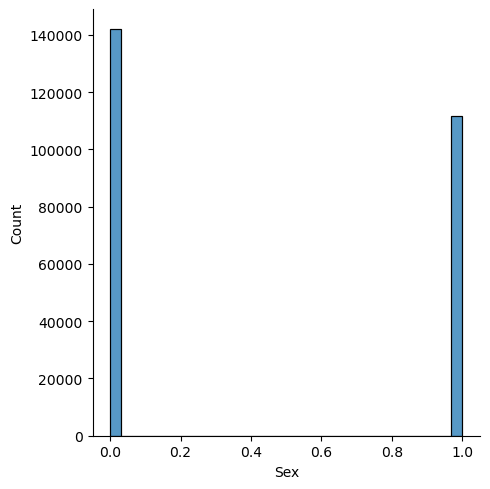

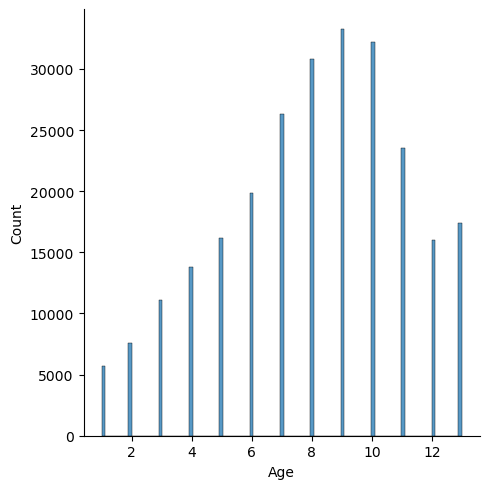

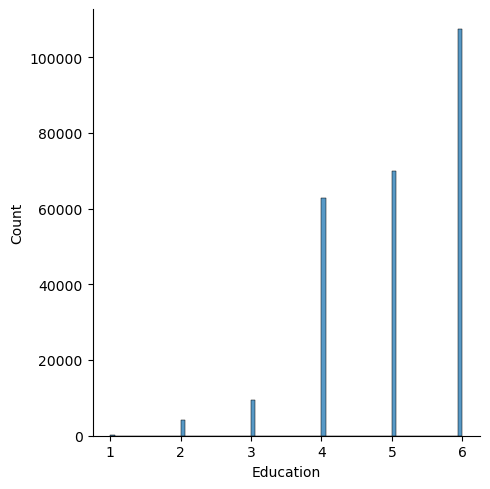

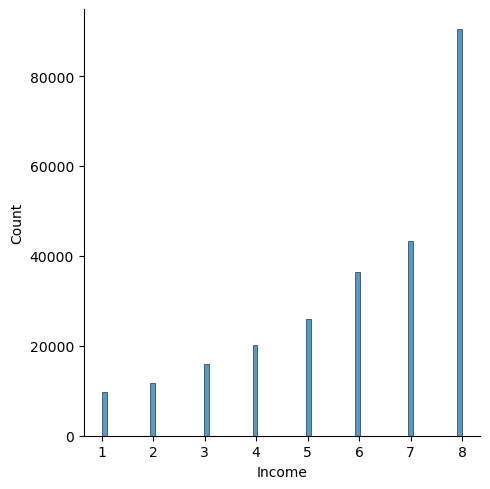

In [7]:
#visulaizing every feature distribution
for i in data.columns:
    sns.displot(data[i])
    plt.show()

In [8]:
#Separate features with output
x_df = data.drop('HeartDiseaseorAttack', axis=1)
y_df = data['HeartDiseaseorAttack']
print(x_df.head())
print(y_df.head())

   HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  Diabetes  PhysActivity  \
0       1         1          1   40       1       0         0             0   
1       0         0          0   25       1       0         0             1   
2       1         1          1   28       0       0         0             0   
3       1         0          1   27       0       0         0             1   
4       1         1          1   24       0       0         0             1   

   Fruits  Veggies  ...  AnyHealthcare  NoDocbcCost  GenHlth  MentHlth  \
0       0        1  ...              1            0        5        18   
1       0        0  ...              0            1        3         0   
2       1        0  ...              1            1        5        30   
3       1        1  ...              1            0        2         0   
4       1        1  ...              1            0        2         3   

   PhysHlth  DiffWalk  Sex  Age  Education  Income  
0        15         1    0 

**Data pre-processing**
* The minmax scaler is used to normalize the data.


In [9]:
#Data Preprocessing
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_df = scaler.fit_transform(x_df)

In [10]:
#Split data into training and testing set
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

print(x_train.shape)
print(x_test.shape)

(202928, 21)
(25366, 21)


**Model Creation and training**
* The model creation is done using keras tuner to get the best model out of different number of specified layers, neurons, and even learning rate of the optimizer.
* The model will train with 200 epoch before evaluating it's accuracy to choose the best model.


In [13]:
#Model Building using keras tuner
def build_model(hp):
  model = Sequential()

  for i in range(hp.Int('num_layers', 1, 3)):  #number of layers choice
    model.add(Dense(
        units=hp.Choice('units_' + str(i), [8, 16, 32]), #neurons choice
        activation='relu'
    ))
  model.add(Dense(1, activation='sigmoid'))

  learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.1, sampling='LOG') #learning rate choice
  model.compile(optimizer = Adam(learning_rate=learning_rate),loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [14]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss', #for the validation set accuracy
    max_trials=5)

I0000 00:00:1729285482.643360   21032 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-19 00:04:42.644291: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [15]:
tuner.search(x_train, y_train, epochs=200, validation_data=(x_val, y_val))
best_model = tuner.get_best_models()[0] #get the best model

Trial 1 Complete [00h 19m 58s]
val_loss: 0.23690921068191528

Best val_loss So Far: 0.23690921068191528
Total elapsed time: 00h 19m 58s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
3                 |3                 |num_layers
8                 |8                 |units_0
0.00093626        |0.004486          |learning_rate
32                |8                 |units_1
16                |8                 |units_2

Epoch 1/200
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9056 - loss: 0.2693 - val_accuracy: 0.9079 - val_loss: 0.2437
Epoch 2/200
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 6s 976us/step - accuracy: 0.9071 - loss: 0.2416 - val_accuracy: 0.9078 - val_loss: 0.2390
Epoch 3/200
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 6s 958us/step - accuracy: 0.9075 - loss: 0.2385 - val_accuracy: 0.9074 - val_loss: 0.2383
Epoch 4/200
6342/6342 ━━━━━━━━━━━━━━━━━━━━ 6s 964us/step - accuracy: 0.9070 - loss: 0.2398 - val_accuracy: 0.9081 - val_loss: 0.2403
Epoch 5/200
63

KeyboardInterrupt: 

**Model Testing**